In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from PIL import Image
from torchsummary import summary
import torch.nn as nn
from utils import fit_model_unet, show_sample, show_sample_output, plot_curves, unet_dice_loss
from unet import UNet

In [22]:
class OxfordPetSegmentationDataset(OxfordIIITPet):
    def __init__(self, root="./data", split='trainval', transform_img=None, transform_tar=None, download=True):
        super().__init__(root=root, split=split, target_types='segmentation', download=download)
        self.transform_img = transform_img
        self.transform_tar = transform_tar

    def __getitem__(self, index):
        image_path, label_path = self._images[index], self._segs[index]
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform_img is not None:
            image = self.transform_img(image)

        if self.transform_tar is not None:
            label = self.transform_tar(label)
            label_one = torch.nn.functional.one_hot(label.squeeze().type(torch.LongTensor), num_classes=3)
            label_one = label_one.permute(2, 0, 1)

        return image, label, label_one

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.Lambda(lambda x: (x - 1).squeeze().type(torch.LongTensor))
])

# Create datasets and dataloaders
batch_size = 32

trainset = OxfordPetSegmentationDataset(
    root='./data',
    split='trainval',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = OxfordPetSegmentationDataset(
    root='./data',
    split='test',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


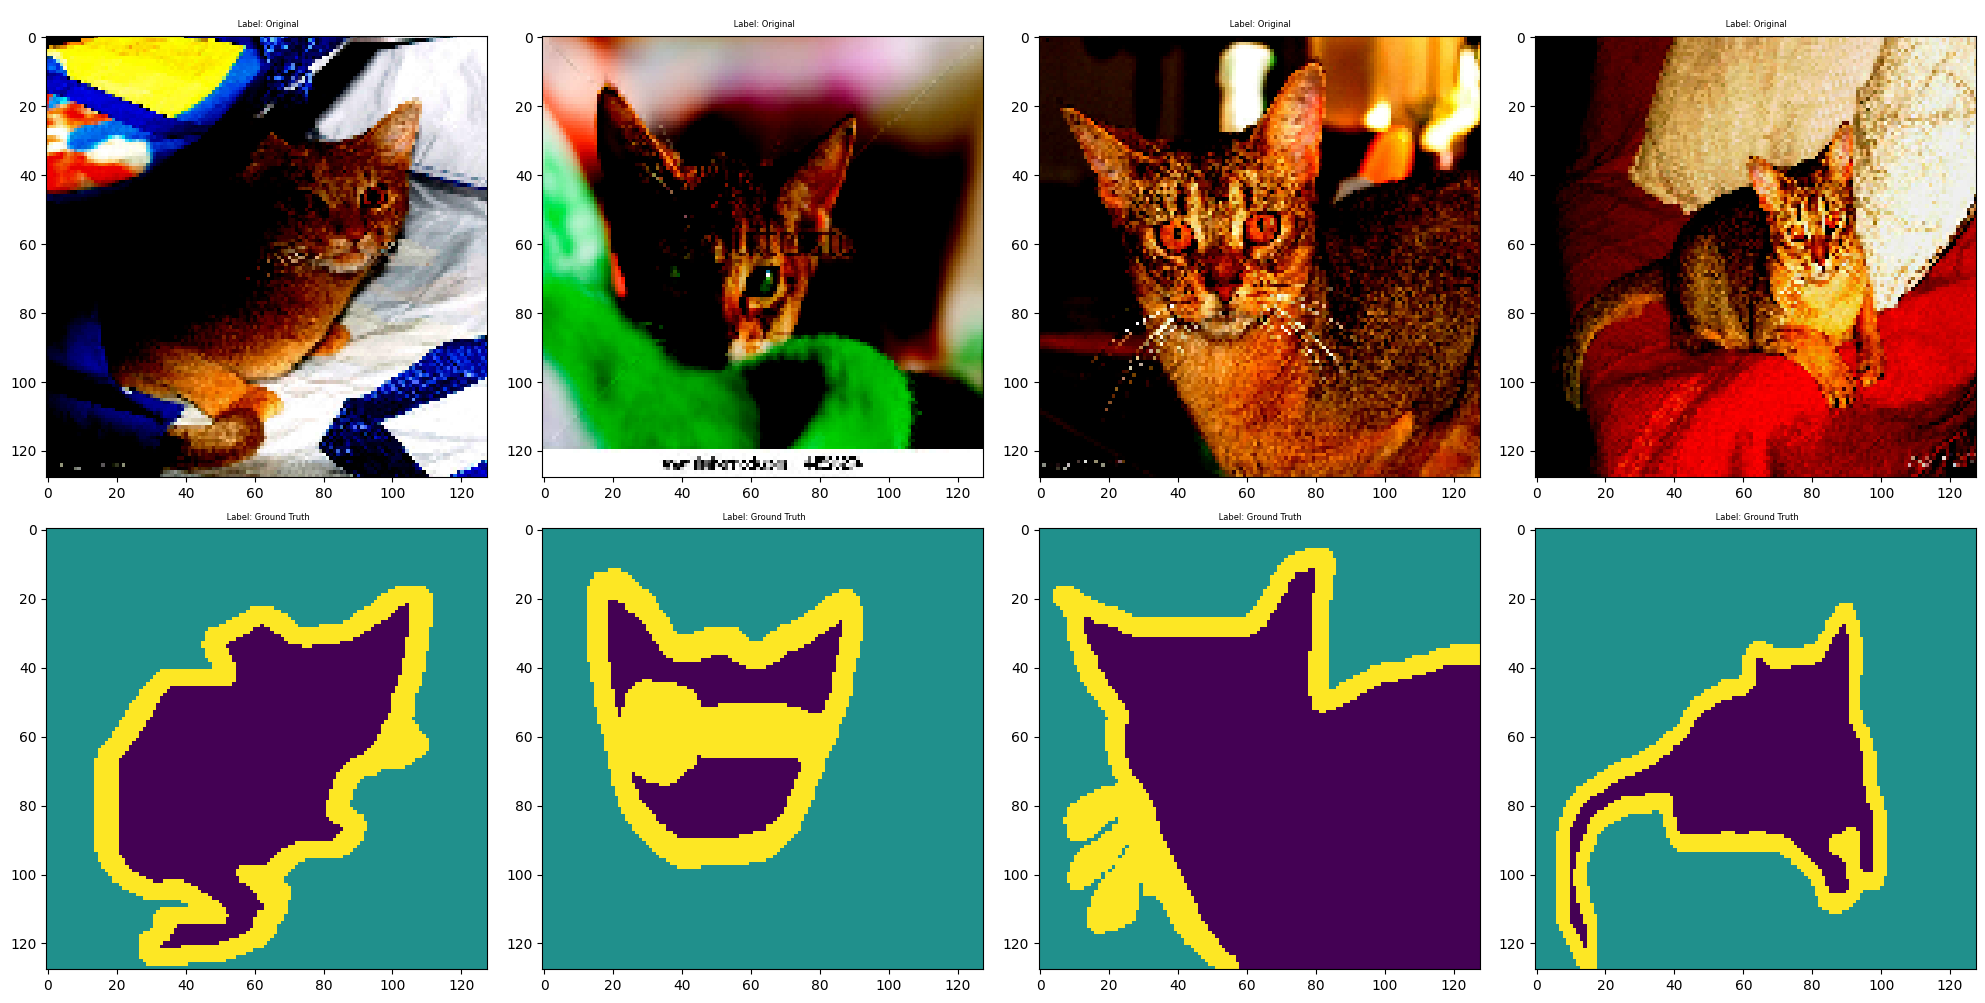

In [5]:
show_sample(trainset)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## MP+Tr+BCE

In [8]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [9]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [10]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 60.37485793232918


Test set: Average loss=57.192008942365646

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 39.48090350627899


Test set: Average loss=34.98484364151955

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 32.261842876672745


Test set: Average loss=29.697382241487503

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  2.99it/s]

Training Loss: 28.809354156255722


Test set: Average loss=33.27591806650162

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 26.86495779454708


Test set: Average loss=27.592739328742027

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  2.99it/s]

Training Loss: 25.748286694288254


Test set: Average loss=25.719892039895058

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 24.226193368434906


Test set: Average loss=26.529552906751633

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  2.98it/s]

Training Loss: 23.166266083717346


Test set: Average loss=22.98848305642605

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 22.00610089302063


Test set: Average loss=23.237125799059868

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 21.21628727018833


Test set: Average loss=23.632740512490273

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 20.789842411875725


Test set: Average loss=24.055663779377937

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 19.619911953806877


Test set: Average loss=21.829696968197823

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 19.032412886619568


Test set: Average loss=30.4789617061615

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.01it/s]

Training Loss: 18.43466629087925


Test set: Average loss=22.932288989424706

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 17.820370346307755


Test set: Average loss=22.237462148070335


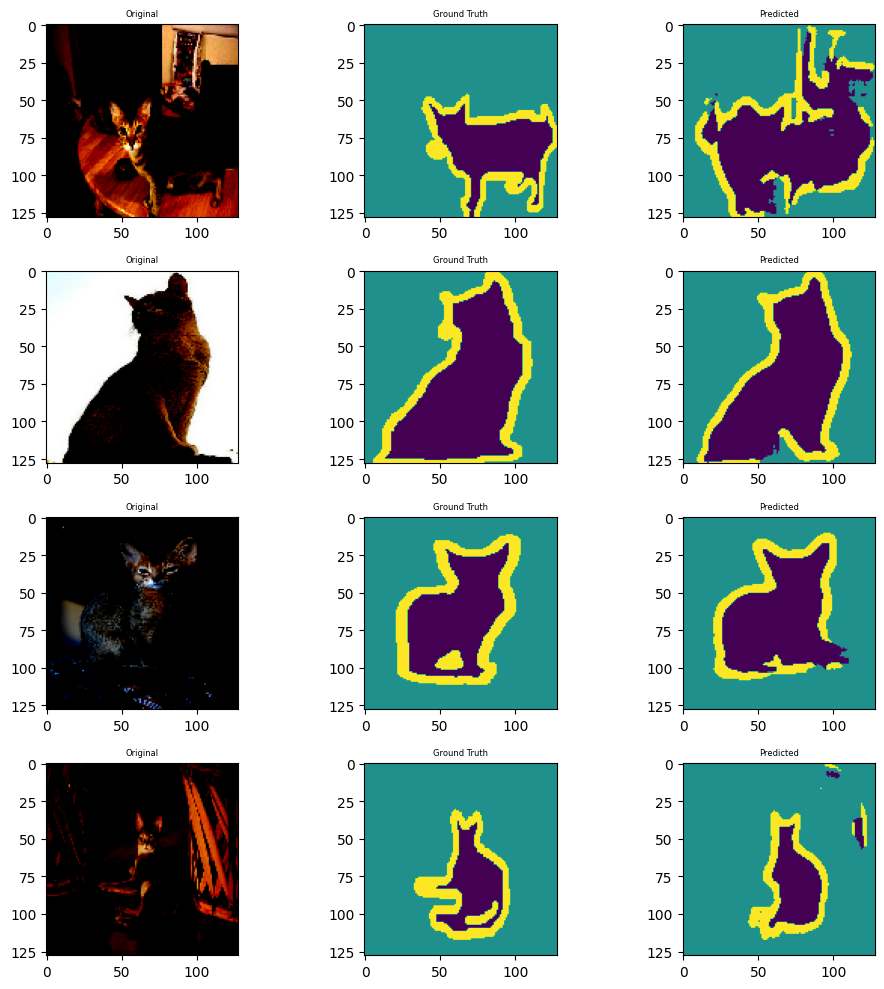

In [12]:
show_sample_output(model,testloader,device,image_no=4)

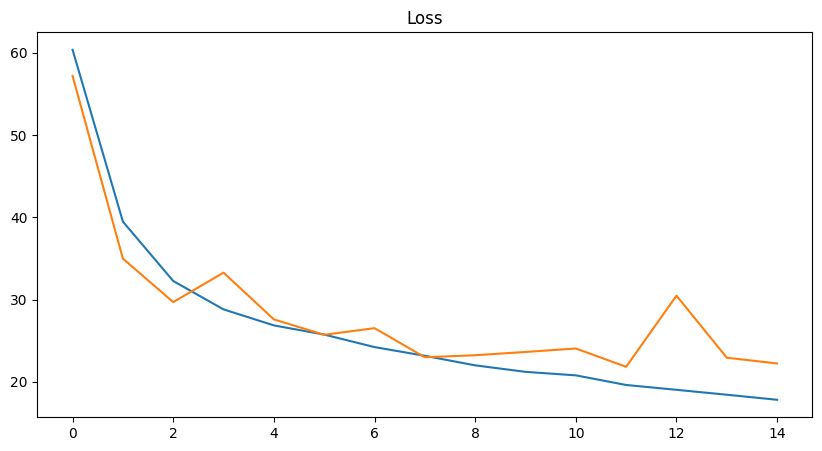

In [14]:
plot_curves(train_losses, test_losses)

## MP+Tr+Dice Loss

In [16]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [17]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.49it/s]

Training Loss: -654.3620654344559


Test set: Average loss=-108.46251499652863

 EPOCH: 2 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.52it/s]

Training Loss: 1184.9120664596558


Test set: Average loss=-161.49091792106628

 EPOCH: 3 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -1889.8569240570068


Test set: Average loss=-222.142884016037

 EPOCH: 4 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.52it/s]

Training Loss: -2043.5531768798828


Test set: Average loss=-752.3111634254456

 EPOCH: 5 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.49it/s]

Training Loss: -2176.4003105163574


Test set: Average loss=841.9698553085327

 EPOCH: 6 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -2276.2212448120117


Test set: Average loss=-577.9124026298523

 EPOCH: 7 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.52it/s]

Training Loss: -2437.359817504883


Test set: Average loss=-851.3899884223938

 EPOCH: 8 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -2630.486885070801


Test set: Average loss=-1597.3957905769348

 EPOCH: 9 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -2809.4522972106934


Test set: Average loss=-489.9377975463867

 EPOCH: 10 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -3061.486026763916


Test set: Average loss=-871.6384930610657

 EPOCH: 11 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -3382.3283195495605


Test set: Average loss=5240.289060592651

 EPOCH: 12 (LR: 0.001)


100%|██████████| 58/58 [00:39<00:00,  1.49it/s]

Training Loss: -3819.1744499206543


Test set: Average loss=-12302.579448699951

 EPOCH: 13 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -4420.8306884765625


Test set: Average loss=-408.7559711933136

 EPOCH: 14 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.50it/s]

Training Loss: -5588.034606933594


Test set: Average loss=-434.3076243400574

 EPOCH: 15 (LR: 0.001)


100%|██████████| 58/58 [00:38<00:00,  1.51it/s]

Training Loss: -12238.687904596329


Test set: Average loss=83.27209377288818


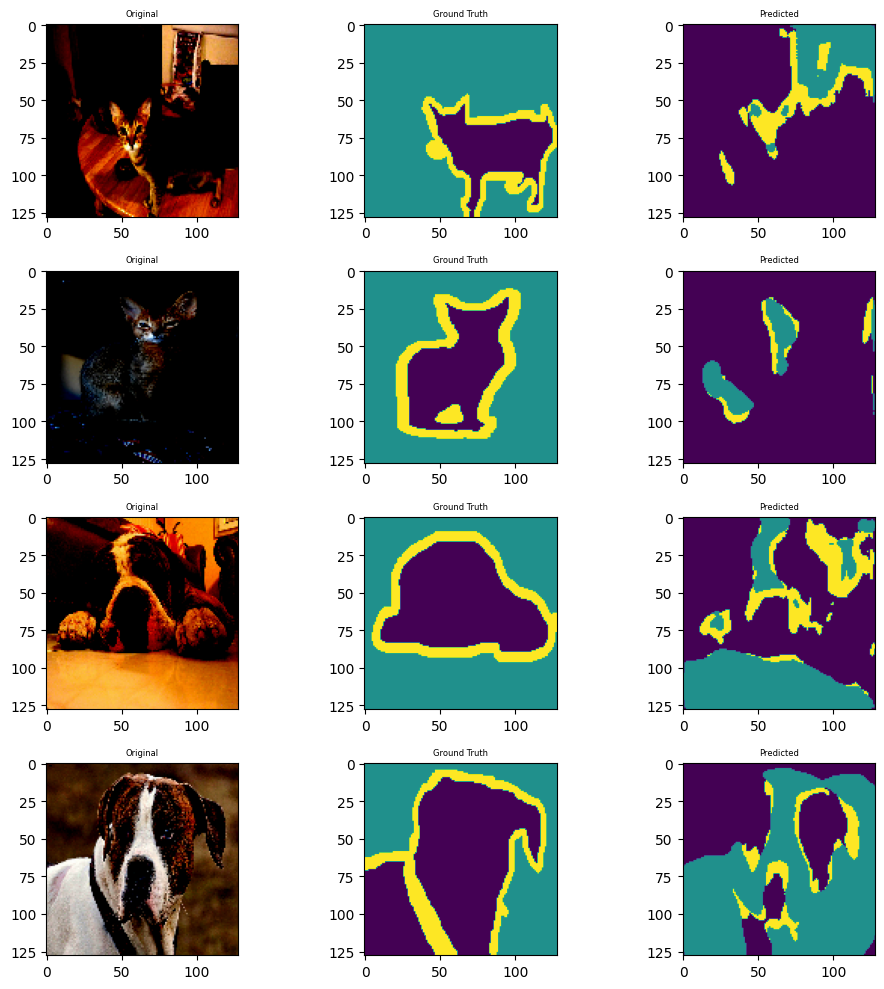

In [20]:
show_sample_output(model,testloader,device,image_no=4)

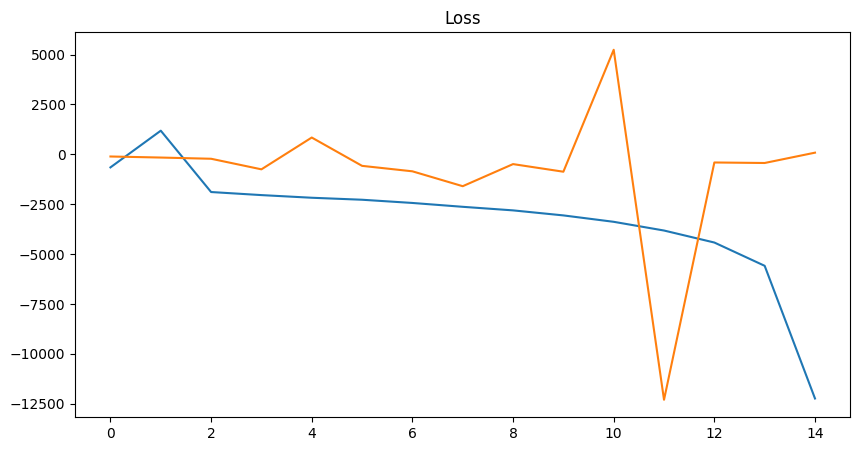

In [21]:
plot_curves(train_losses, test_losses)

## StrConv+Tr+BCE

In [23]:
model = UNet(in_channels = 3, out_channels = 3, pool='StrConv').to(device)

In [24]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [25]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 60.62572172284126


Test set: Average loss=53.251565247774124

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: 42.06479895114899


Test set: Average loss=55.85706877708435

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: 34.4506643563509


Test set: Average loss=33.95248533785343

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 31.16612246632576


Test set: Average loss=28.717300981283188

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 28.34918612241745


Test set: Average loss=28.21758472919464

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 26.794684514403343


Test set: Average loss=28.65428949892521

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 25.984175130724907


Test set: Average loss=30.094114407896996

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 24.609431967139244


Test set: Average loss=24.5270928889513

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 23.781042858958244


Test set: Average loss=24.723795101046562

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 23.012157171964645


Test set: Average loss=26.612336724996567

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 22.2931901961565


Test set: Average loss=24.304842576384544

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: 21.780579015612602


Test set: Average loss=23.780808180570602

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 20.916413962841034


Test set: Average loss=23.233995959162712

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 20.429152563214302


Test set: Average loss=22.15691140294075

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: 20.047022849321365


Test set: Average loss=21.61451717466116


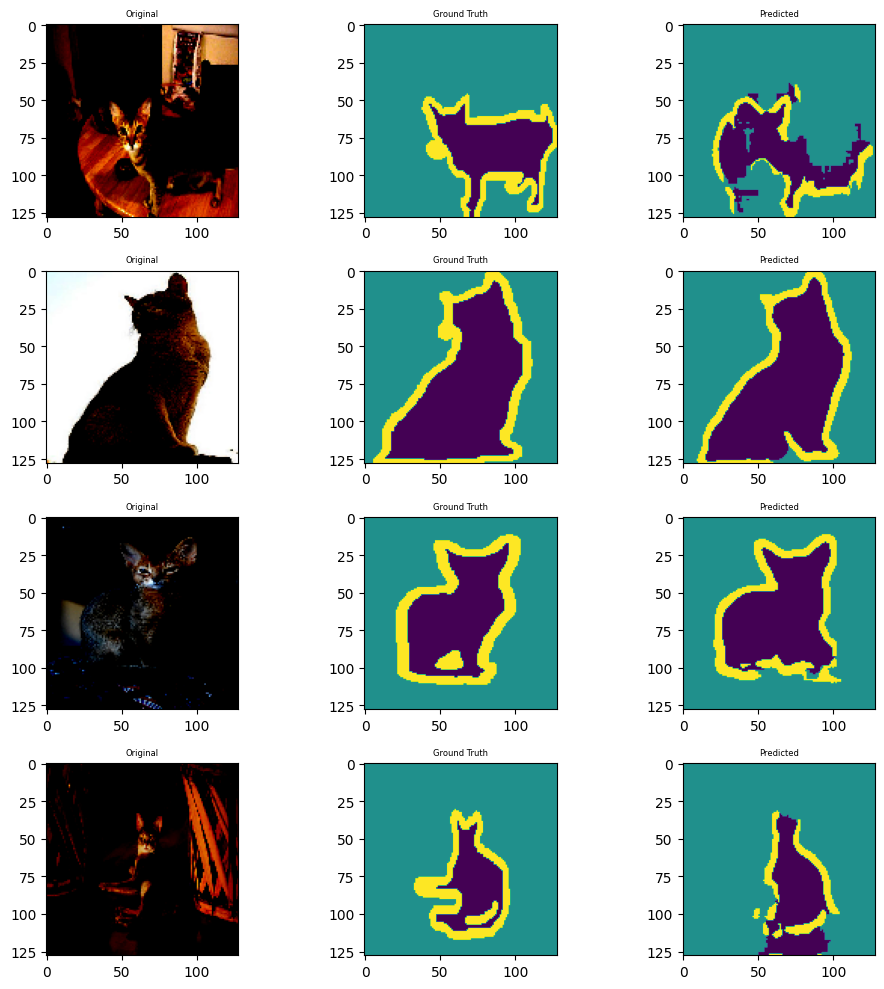

In [27]:
show_sample_output(model,testloader,device,image_no=4)

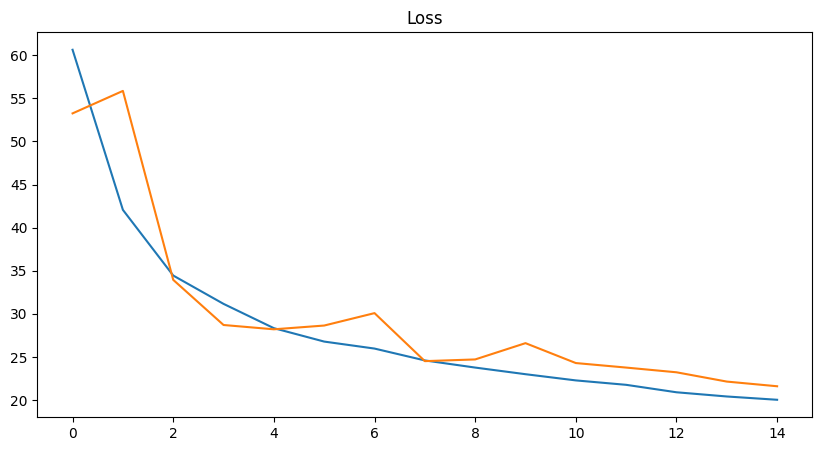

In [28]:
plot_curves(train_losses, test_losses)

## StrConv+Ups+Dice Loss

In [29]:
model = UNet(in_channels = 3, out_channels = 3, mode='upsample', pool='StrConv').to(device)

In [30]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [31]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -2068.525363743305


Test set: Average loss=-2939.051164627075

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -3272.1819248199463


Test set: Average loss=-6242.683734893799

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -5615.308242797852


Test set: Average loss=-2113.757571220398

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -9891.309433281422


Test set: Average loss=-5500.97399520874

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2371.8251152038574


Test set: Average loss=-1621.198314189911

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2580.9655570983887


Test set: Average loss=-1670.3332424163818

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -2779.6091117858887


Test set: Average loss=-2513.124915122986

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -2980.991704940796


Test set: Average loss=-1559.544451713562

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -3124.1796913146973


Test set: Average loss=-7282.808718681335

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -3244.3814907073975


Test set: Average loss=-2279.3665561676025

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.88it/s]

Training Loss: -3385.5778160095215


Test set: Average loss=14196.689867973328

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -3540.5360774993896


Test set: Average loss=2021.5501918792725

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -3676.4603023529053


Test set: Average loss=-3194.902413368225

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -3814.864751815796


Test set: Average loss=-10000.183547019958

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.89it/s]

Training Loss: -4000.924388885498


Test set: Average loss=-5998.71074962616


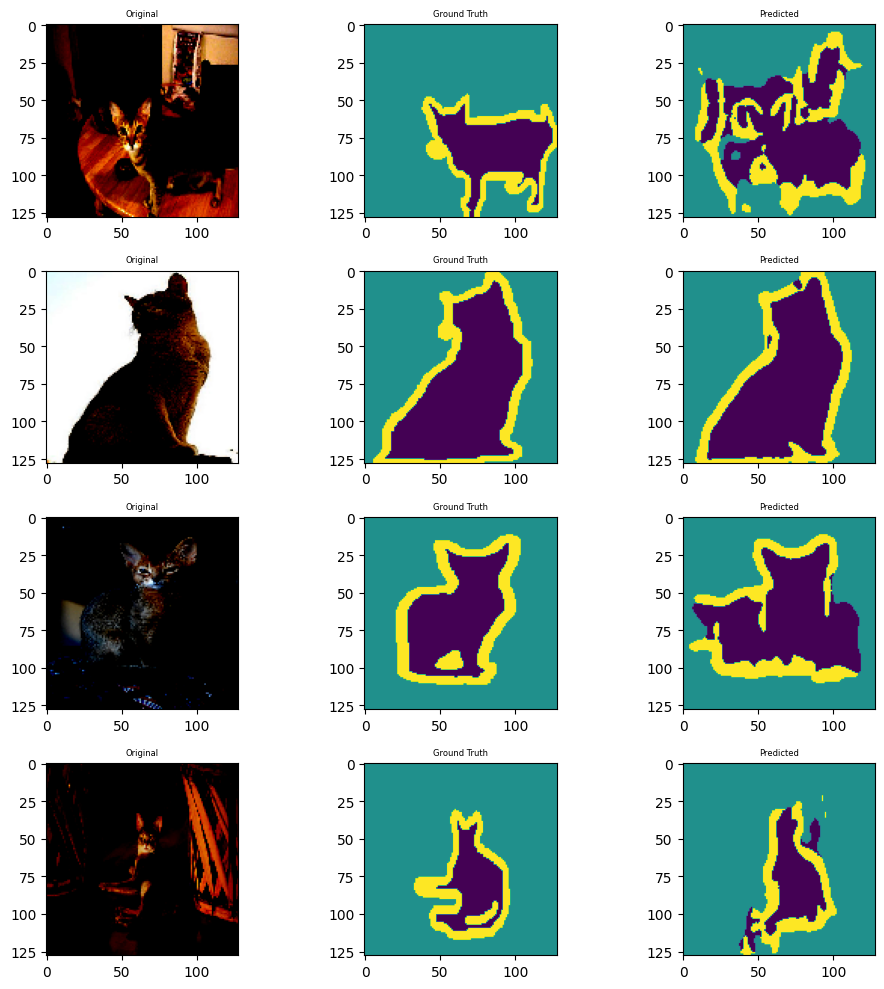

In [33]:
show_sample_output(model,testloader,device,image_no=4)

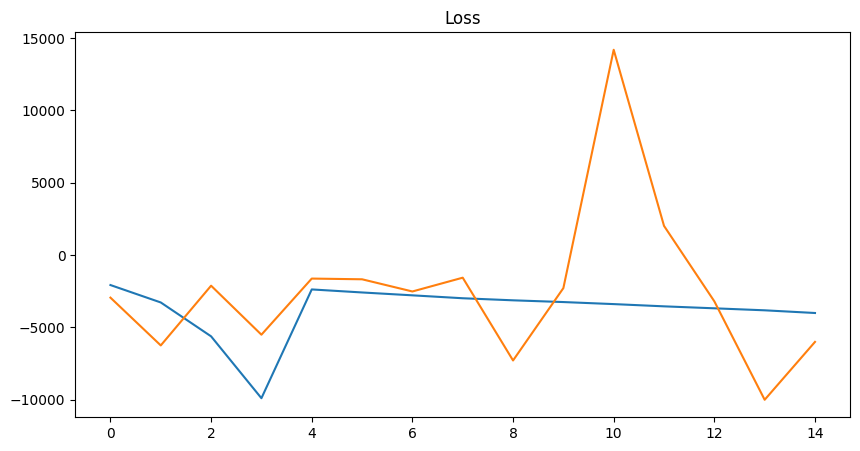

In [34]:
plot_curves(train_losses, test_losses)